In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
(x_train, _), (_, _) = keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)  # (batch,28,28,1)

BUFFER_SIZE = 60000
BATCH_SIZE = 128
LATENT_DIM = 100

train_dataset = (
    tf.data.Dataset.from_tensor_slices(x_train)
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
def build_generator(latent_dim):
    model = keras.Sequential([
        layers.Dense(7*7*256, use_bias=False, input_shape=(latent_dim,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((7, 7, 256)),

        layers.Conv2DTranspose(128, (5,5), strides=1, padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5,5), strides=2, padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(1, (5,5), strides=2, padding="same", use_bias=False, activation="sigmoid")
    ])
    return model

generator = build_generator(LATENT_DIM)
generator.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 128)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │         1,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

In [ ]:
def build_discriminator():
    model = keras.Sequential([
        layers.Conv2D(64, (5,5), strides=2, padding="same", input_shape=[28,28,1]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5,5), strides=2, padding="same"),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1, activation="sigmoid")
    ])
    return model

discriminator = build_discriminator()
discriminator.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=False)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = keras.optimizers.Adam(1e-4)
discriminator_optimizer = keras.optimizers.Adam(1e-4)

In [ ]:
EPOCHS = 50
noise_dim = LATENT_DIM
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.suptitle(f"Epoch {epoch}")
    plt.show()

Epoch 1/50 | Gen Loss: 0.5141 | Disc Loss: 2.1180


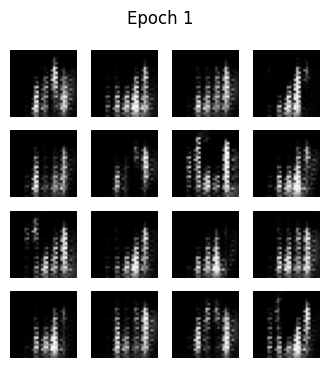

Epoch 2/50 | Gen Loss: 0.8018 | Disc Loss: 1.3303


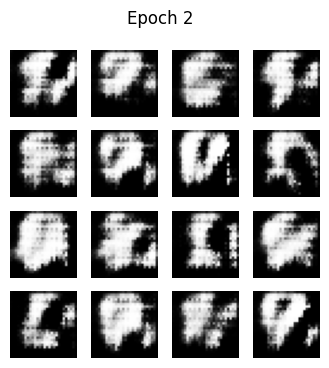

Epoch 3/50 | Gen Loss: 0.6072 | Disc Loss: 1.8260


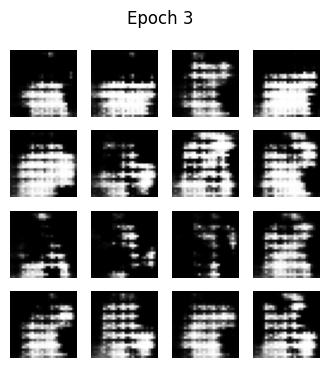

Epoch 4/50 | Gen Loss: 1.1200 | Disc Loss: 1.0703


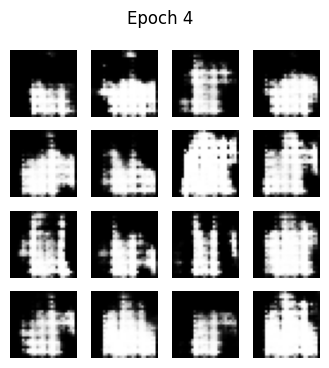

Epoch 5/50 | Gen Loss: 1.1268 | Disc Loss: 1.0281


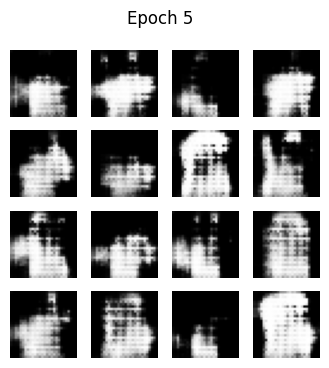

Epoch 6/50 | Gen Loss: 1.0639 | Disc Loss: 1.1432


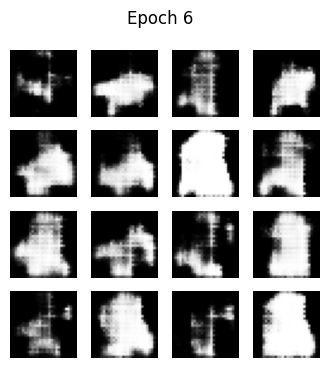

Epoch 7/50 | Gen Loss: 0.8599 | Disc Loss: 1.2691


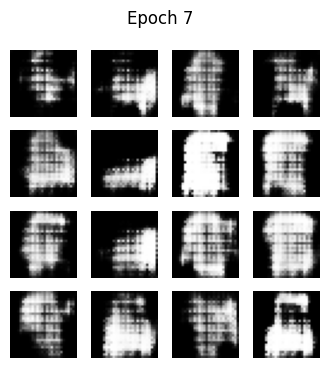

Epoch 8/50 | Gen Loss: 1.1131 | Disc Loss: 0.9377


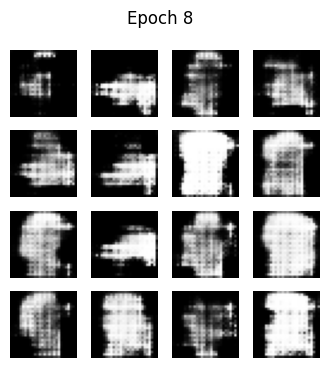

Epoch 9/50 | Gen Loss: 0.9595 | Disc Loss: 1.1586


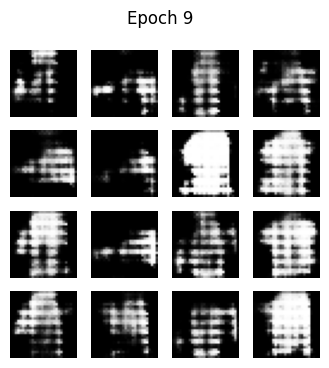

Epoch 10/50 | Gen Loss: 1.0047 | Disc Loss: 1.1729


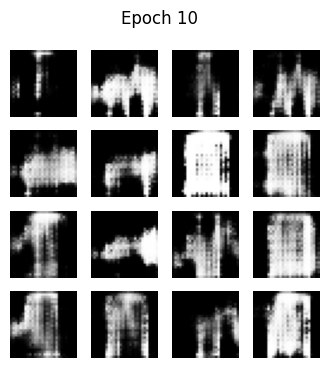

Epoch 11/50 | Gen Loss: 1.3046 | Disc Loss: 0.9413


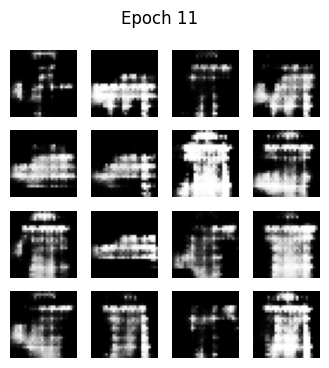

Epoch 12/50 | Gen Loss: 1.0934 | Disc Loss: 1.2514


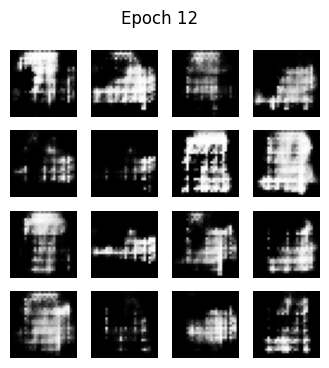

Epoch 13/50 | Gen Loss: 1.4391 | Disc Loss: 0.7541


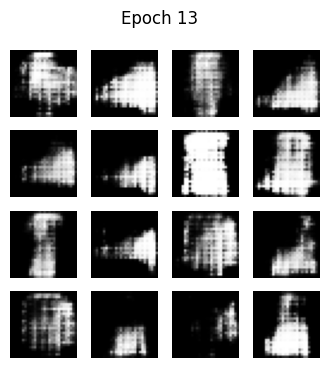

Epoch 14/50 | Gen Loss: 1.3109 | Disc Loss: 0.9119


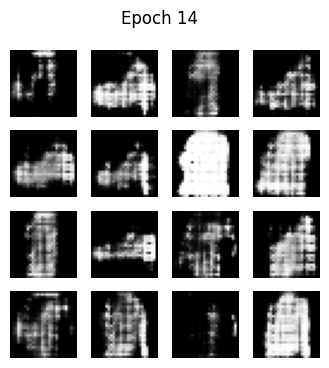

Epoch 15/50 | Gen Loss: 1.6118 | Disc Loss: 0.5426


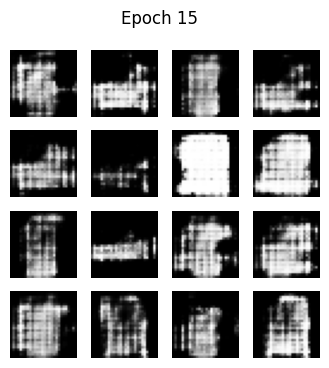

Epoch 16/50 | Gen Loss: 1.3595 | Disc Loss: 0.7928


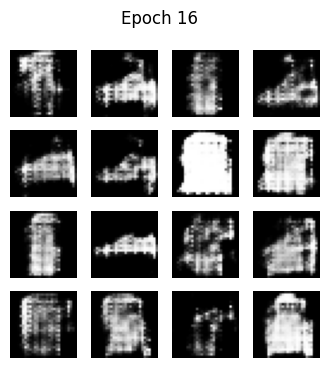

Epoch 17/50 | Gen Loss: 1.5633 | Disc Loss: 0.9087


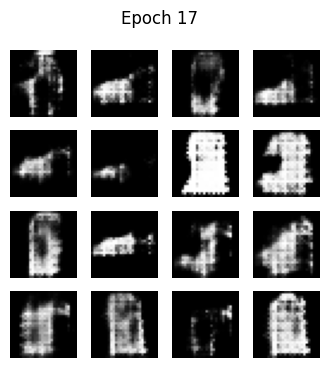

Epoch 18/50 | Gen Loss: 1.2649 | Disc Loss: 0.9378


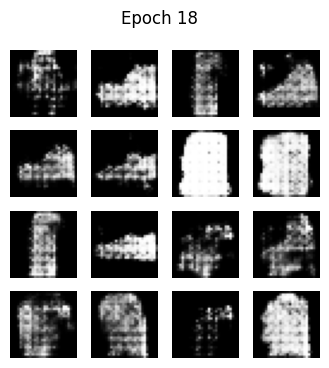

Epoch 19/50 | Gen Loss: 1.4895 | Disc Loss: 0.9556


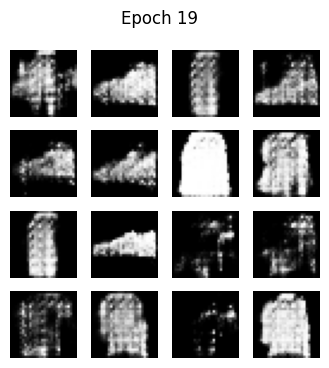

Epoch 20/50 | Gen Loss: 1.5406 | Disc Loss: 0.6913


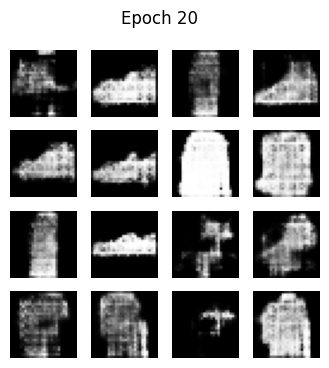

Epoch 21/50 | Gen Loss: 1.4916 | Disc Loss: 0.8154


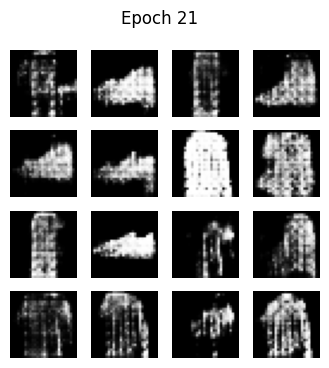

Epoch 22/50 | Gen Loss: 1.6135 | Disc Loss: 0.8874


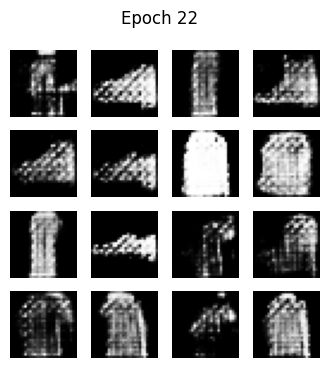

Epoch 23/50 | Gen Loss: 1.2264 | Disc Loss: 1.1964


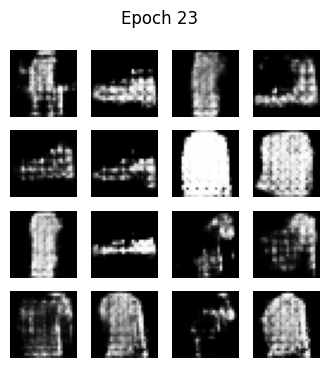

Epoch 24/50 | Gen Loss: 1.0490 | Disc Loss: 1.1415


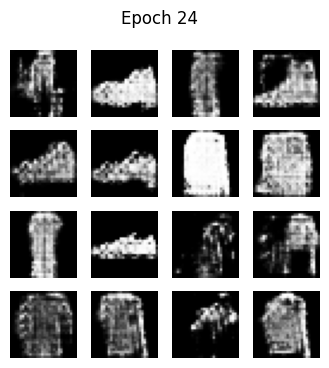

Epoch 25/50 | Gen Loss: 1.1351 | Disc Loss: 1.0996


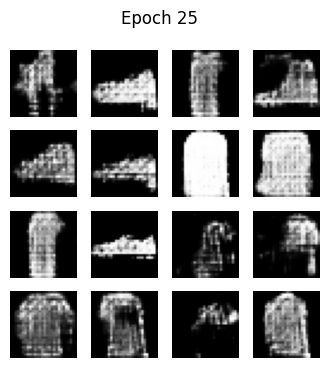

Epoch 26/50 | Gen Loss: 1.2182 | Disc Loss: 1.0761


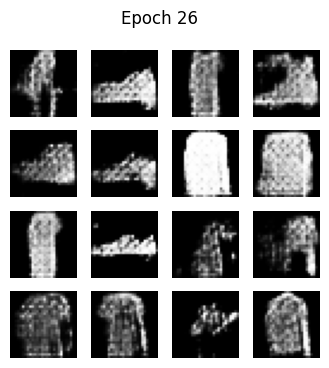

Epoch 27/50 | Gen Loss: 1.1530 | Disc Loss: 1.1477


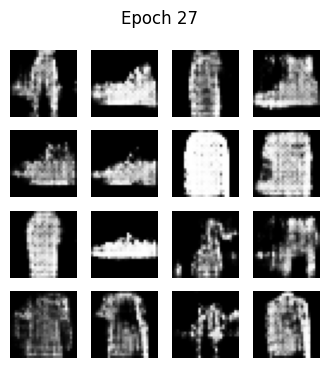

Epoch 28/50 | Gen Loss: 1.1837 | Disc Loss: 1.1471


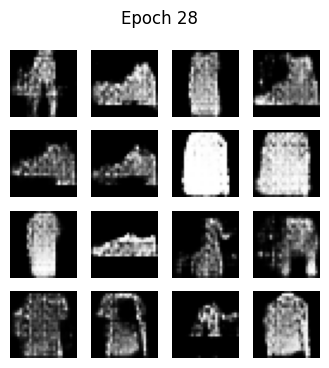

Epoch 29/50 | Gen Loss: 1.0854 | Disc Loss: 1.1311


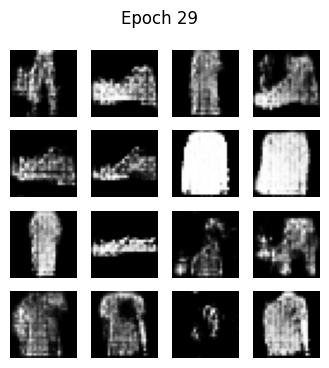

Epoch 30/50 | Gen Loss: 1.2231 | Disc Loss: 1.2225


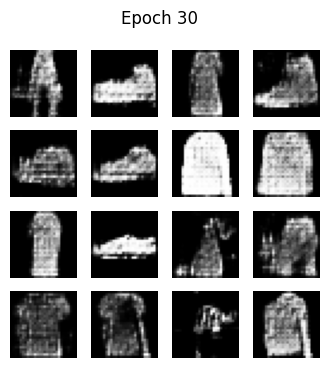

Epoch 31/50 | Gen Loss: 1.2356 | Disc Loss: 0.9817


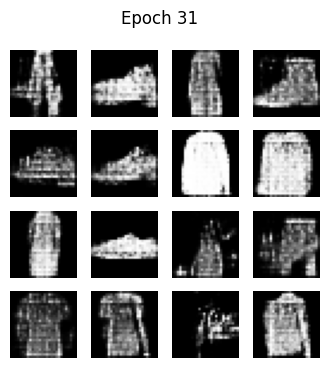

Epoch 32/50 | Gen Loss: 0.9900 | Disc Loss: 1.1680


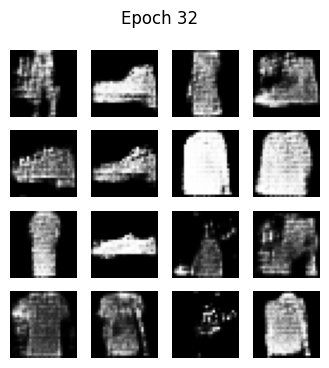

Epoch 33/50 | Gen Loss: 1.1009 | Disc Loss: 1.0445


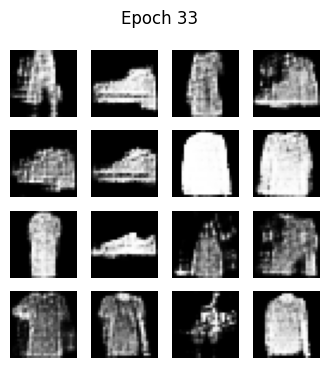

Epoch 34/50 | Gen Loss: 1.1236 | Disc Loss: 1.0547


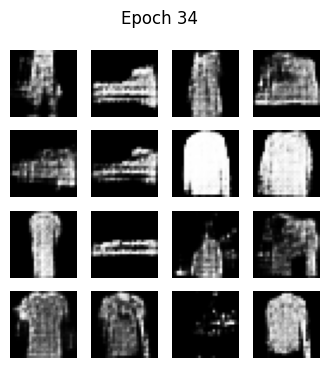

Epoch 35/50 | Gen Loss: 0.7996 | Disc Loss: 1.4039


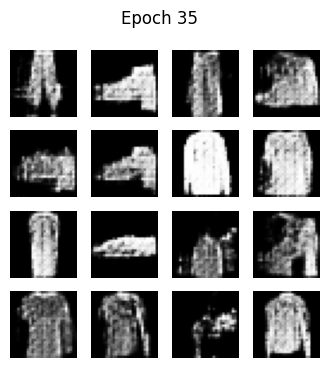

Epoch 36/50 | Gen Loss: 1.2040 | Disc Loss: 1.0501


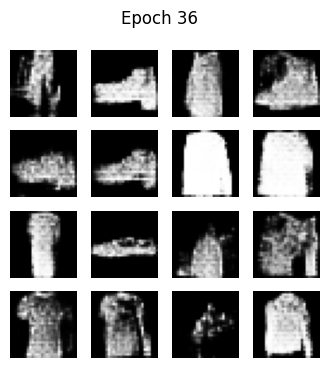

Epoch 37/50 | Gen Loss: 1.1558 | Disc Loss: 1.0537


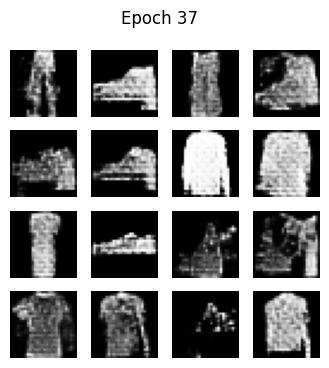

Epoch 38/50 | Gen Loss: 0.9821 | Disc Loss: 1.0658


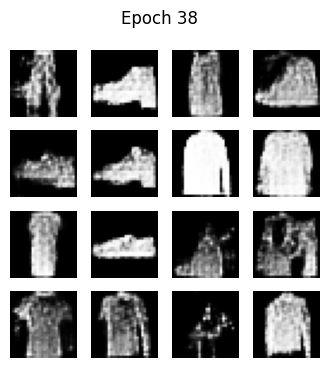

Epoch 39/50 | Gen Loss: 1.1286 | Disc Loss: 1.1205


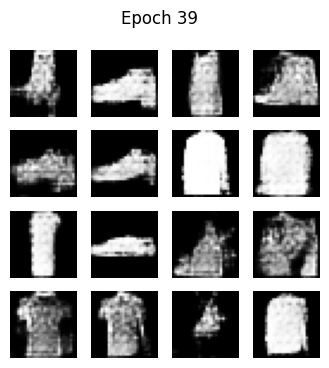

Epoch 40/50 | Gen Loss: 1.2319 | Disc Loss: 1.0254


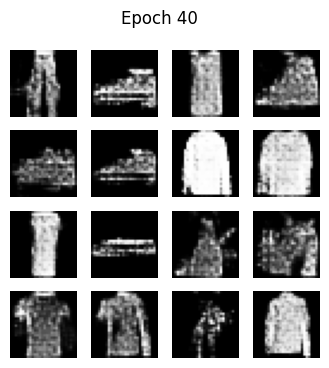

Epoch 41/50 | Gen Loss: 0.9502 | Disc Loss: 1.2281


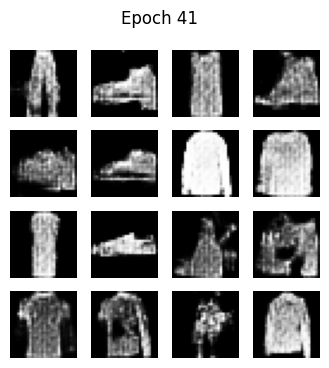

Epoch 42/50 | Gen Loss: 1.0226 | Disc Loss: 1.0378


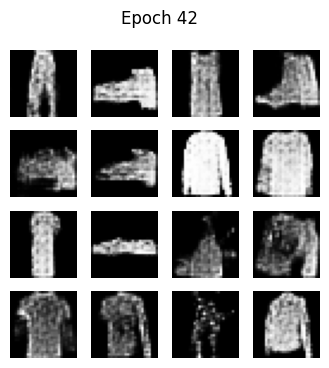

Epoch 43/50 | Gen Loss: 1.1926 | Disc Loss: 1.1588


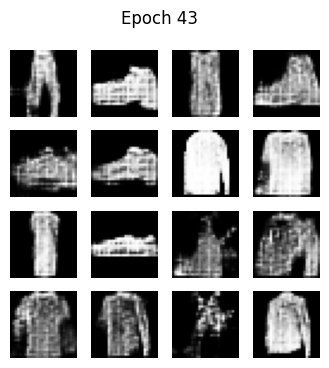

Epoch 44/50 | Gen Loss: 0.9701 | Disc Loss: 1.2013


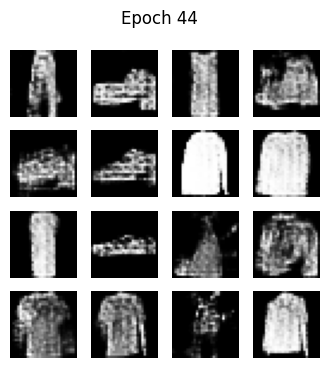

Epoch 45/50 | Gen Loss: 1.3406 | Disc Loss: 1.2076


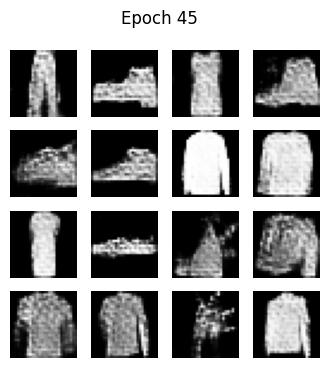

Epoch 46/50 | Gen Loss: 0.9950 | Disc Loss: 1.1123


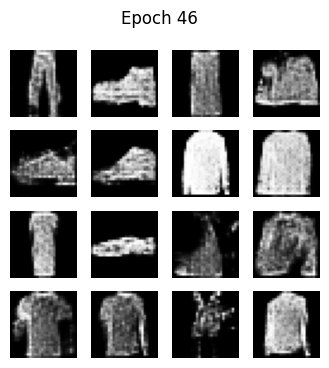

Epoch 47/50 | Gen Loss: 0.9935 | Disc Loss: 1.2505


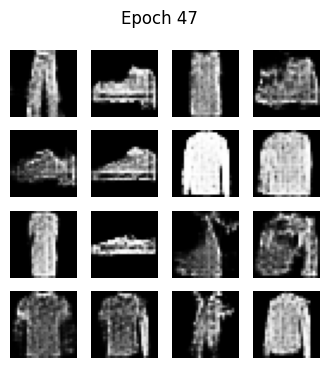

Epoch 48/50 | Gen Loss: 1.0819 | Disc Loss: 1.0928


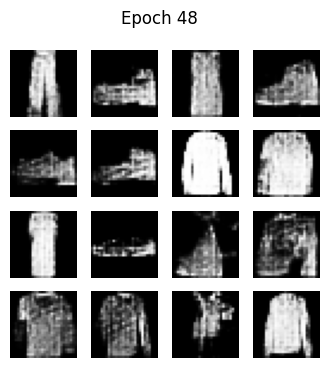

Epoch 49/50 | Gen Loss: 1.2250 | Disc Loss: 1.0886


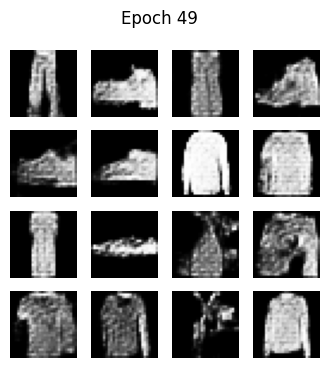

Epoch 50/50 | Gen Loss: 1.0416 | Disc Loss: 1.2379


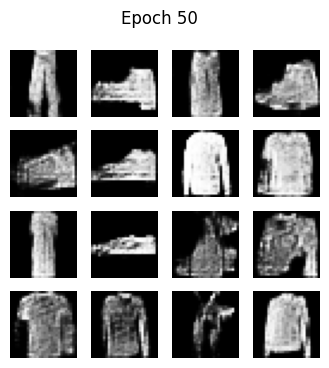

In [ ]:
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            g_loss, d_loss = train_step(image_batch)

        print(f"Epoch {epoch+1}/{epochs} | Gen Loss: {g_loss:.4f} | Disc Loss: {d_loss:.4f}")
        generate_and_save_images(generator, epoch+1, seed)

train(train_dataset, EPOCHS)